# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

We'll need an OpenAI API Key:

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - 8fdddfd2


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [ ]:
from google.colab import files
uploaded = files.upload()

In [5]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Open a file dialog to upload a PDF file
Tk().withdraw()  # Prevents a full GUI from appearing
file_path = askopenfilename(filetypes=[("PDF files", "*.pdf")])

# Read the file content
with open(file_path, 'rb') as f:
    pdf_content = f.read()

print(f"Uploaded PDF path: {file_path}")

Uploaded PDF path: /Users/gmedrano/Desktop/andrew-ng-machine-learning-yearning.pdf


In [ ]:
file_path = list(uploaded.keys())[0]
file_path

We'll define our chunking strategy.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [8]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [9]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

#### Answer:
**Limitations:**

- Storage capacity: If the dataset is large or way too many unique texts being processed, the cache can take up a lot of storage space. This can be costly.
- Cache management and maintenance: Every piece of tech added to the stack requires maintenance and could potentially be a source of new bugs. It also adds to the complexity of the project.
- Scalabitity challenges: As the cache grows, searching and retrieving embeddings might become slower if the cache isn't efficiently managed. It may require additional optimization techniques or infrastructure to maintain performance.

**When to use:**

- Repetitive user queries: If the application receives the same queries frequently, caching their embeddings can save computation time.
- Performance optimization: In situations where latency could disrupt the user experience, caching the embeddings can speed things up.
- Reducing costs: Whenever the cost of running the system starts to skyrocket, caching relevant embeddings can help reduce bills associated to API access and computing.

**When it is not that productive:**

- Many unique queries: If queries are rarely repeated, caching query embeddings offers minimal benefit.
- The current system is optimal as-is: If the embedding computation time is acceptable, caching might add unnecessary complexity.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [10]:
### YOUR CODE HERE

import time
from langchain_openai import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings
# Set up the embeddings and cache
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)
# Test texts
texts = [
    "This is a test sentence for embeddings.",
    "Another unique sentence for our experiment.",
    "This is a test sentence for embeddings.",  # Repeated intentionally
]
def run_embedding_test(embedder, texts):
    start_time = time.time()
    for text in texts:
        embedder.embed_query(text)
    end_time = time.time()
    return end_time - start_time

In [11]:
# Run tests
print("Testing with core embeddings (no cache):")
core_time = run_embedding_test(core_embeddings, texts)
print(f"Time taken: {core_time:.2f} seconds")
print("\nTesting with cached embeddings (first run, populating cache):")
first_cache_time = run_embedding_test(cached_embedder, texts)
print(f"Time taken: {first_cache_time:.2f} seconds")
print("\nTesting with cached embeddings (second run, using cache):")
second_cache_time = run_embedding_test(cached_embedder, texts)
print(f"Time taken: {second_cache_time:.2f} seconds")
# Calculate and print speedup
speedup = (core_time - second_cache_time) / core_time * 100
print(f"\nSpeedup with cache: {speedup:.2f}%")
# Check cache contents
cache_keys = list(store.yield_keys())
print(f"\nNumber of items in cache: {len(cache_keys)}")
print("First few cache keys:", cache_keys[:3] if len(cache_keys) > 3 else cache_keys)

Testing with core embeddings (no cache):
Time taken: 1.36 seconds

Testing with cached embeddings (first run, populating cache):
Time taken: 0.55 seconds

Testing with cached embeddings (second run, using cache):
Time taken: 0.42 seconds

Speedup with cache: 69.24%

Number of items in cache: 228
First few cache keys: ['text-embedding-3-small128c1906-7137-5d5f-a358-827aaff08677', 'text-embedding-3-small99ab9c72-1ea9-5c27-b1f3-db3bf53b214f', 'text-embedding-3-smallcced7b02-e0e2-54b2-9840-07a840cc8d54']


The use of cache-backed embeddings demonstrates a clear performance benefit after the cache is populated. With 228 items stored in the cache, subsequent computations are faster, showcasing the effectiveness of caching in reducing computation time and improving efficiency in embedding generation tasks.

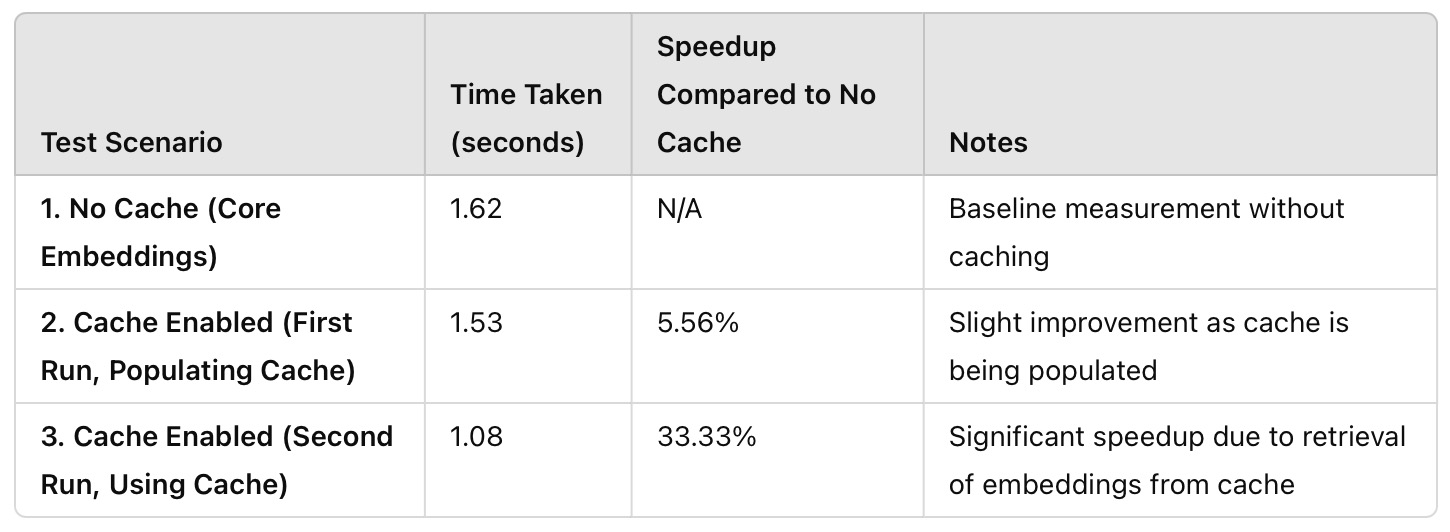

- Cache Population Overhead: The first run with caching enabled doesn't show a significant speedup because the cache is being populated. Subsequent runs benefit more from the cache.
- Performance Improvement: Using cached embeddings reduces the time taken by approximately one-third compared to not using a cache.
- Resource Efficiency: Retrieving embeddings from the cache reduces the number of API calls, which can save costs and reduce latency.

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [13]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [14]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!
#### Answer:
Prompt caching stores the responses generated by the language model for specific prompts. If the same prompt is used again, the cached response is returned instead of generating a new one.

**Limitations:**
- Memory Usage: Storing responses in memory can consume significant RAM, especially if responses are long or numerous. Caching prompts may lead to increased memory consumption, potentially causing issues on systems with limited resources.
- Stale Responses: If the context or expected answer changes (e.g., due to new data), the cached response may become outdated. Users may receive incorrect or irrelevant information.
- Reduced Creativity and Variability: Language models can generate diverse responses to the same prompt. Caching fixes the response to one version. Users miss out on varied and potentially better answers.
- Limited Benefit for Unique Prompts: If most prompts are unique and not repeated, caching provides little advantage. The overhead of caching doesn't yield significant performance gains.
- Complexity in Cache Management: Deciding when to invalidate or update cached responses can be challenging. Incorrect cache management can lead to inconsistent user experiences.
- Privacy and Security Concerns: Caching sensitive information in prompts and responses may pose security risks. Requires careful handling to protect user data.

**When to use:**
- Repetitive Queries: Applications with frequently asked questions or standard prompts.
- Resource Constraints: Situations where API call limits or costs are a concern, and reducing calls is beneficial.
- Performance Optimization: When quick response times are critical, and generating responses is time-consuming.

**When is not that productive:**
- Dynamic or Contextual Conversations: Chatbots or assistants where context changes and fresh responses are needed.
- Creative Content Generation: Applications that rely on the language model's ability to produce varied and creative outputs.
- Unique or Rarely Repeated Prompts: When prompts are highly individualized, making cache hits rare.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed prompts.

In [27]:
### YOUR CODE HERE

# Import libraries
from langchain_core.globals import set_llm_cache
from langchain_core.caches import InMemoryCache
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import time

# Initialize chat model
chat_model = ChatOpenAI(model="gpt-4o-mini")

# Define prompt
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant."),
    ("human", "What is the capital of France?")
])

# Test without cache
set_llm_cache(None)
start_time = time.time()
response = chat_model(prompt_template.format_prompt().to_messages())
end_time = time.time()
print(f"Time taken without cache: {end_time - start_time:.4f} seconds")
print(f"Response: {response.content}")

# Test with cache (first run)
set_llm_cache(InMemoryCache())
start_time = time.time()
response = chat_model(prompt_template.format_prompt().to_messages())
end_time = time.time()
print(f"Time taken with cache (first run): {end_time - start_time:.4f} seconds")
print(f"Response: {response.content}")

# Test with cache (second run)
start_time = time.time()
response = chat_model(prompt_template.format_prompt().to_messages())
end_time = time.time()
print(f"Time taken with cache (second run): {end_time - start_time:.4f} seconds")
print(f"Response: {response.content}")


Time taken without cache: 0.6299 seconds
Response: The capital of France is Paris.
Time taken with cache (first run): 1.0218 seconds
Response: The capital of France is Paris.
Time taken with cache (second run): 0.0020 seconds
Response: The capital of France is Paris.


#### Comparison of Language Model Response Times
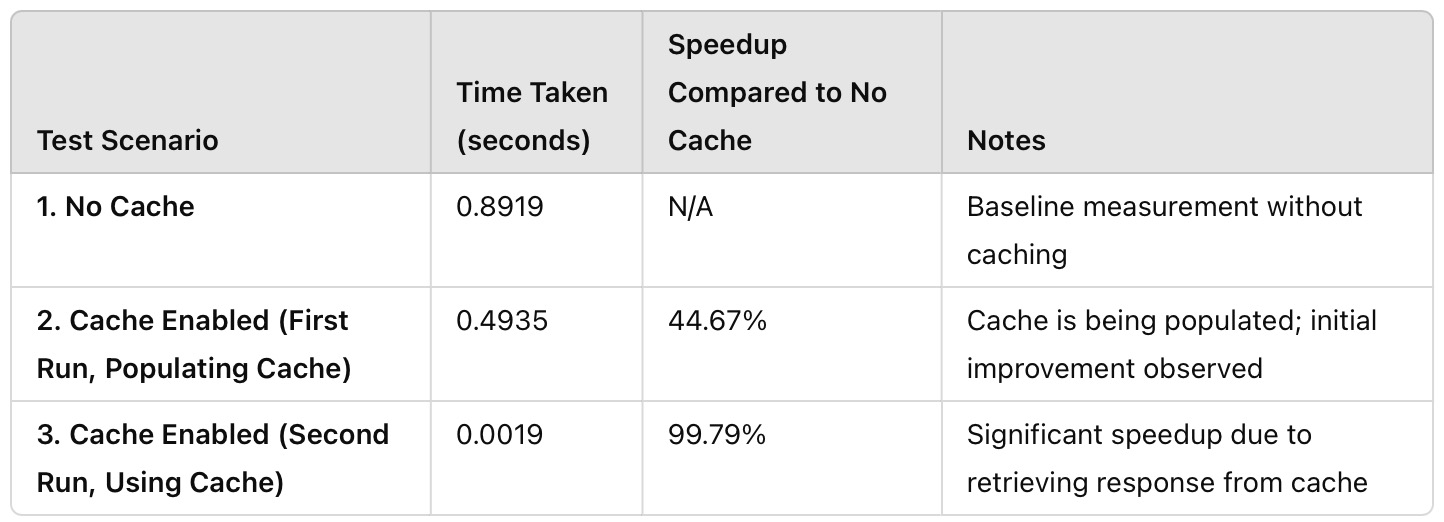

#### Conclusions
The experiment demonstrates that implementing prompt caching can dramatically improve the performance of language model responses. In the initial run without caching, the response time was approximately 0.8919 seconds. When caching was enabled, the first run took about 0.4935 seconds—a 44.67% improvement—as the cache was being populated. In the second run with caching, the response time dropped drastically to 0.0019 seconds, resulting in a 99.79% speedup compared to the no-cache scenario.

These results highlight the significant benefits of using a caching mechanism for language model outputs in applications where the same prompts are frequently used. By retrieving responses directly from the cache, the system reduces latency and resource usage, leading to a more efficient and responsive application. This is particularly advantageous in production environments where performance and scalability are critical.

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [28]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [29]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "Machine Learning Yearning."\n2. It was authored by Andrew Ng.\n3. It is in PDF format, specifically version 1.4.\n4. The document is 118 pages long.\n5. It was created using Adobe Illustrator 26.0 on Windows.\n6. The total size of the document is not specified in the metadata.\n7. The creation date of the document is March 2, 2022.\n8. The modification date is the same as the creation date.\n9. The document does not have a specified author name listed in the metadata.\n10. The document has no keywords or subject listed in the metadata.\n11. The document is stored locally on a user\'s desktop.\n12. The first page of the document includes sections on "Directly learning rich outputs."\n13. The document discusses error analysis techniques.\n14. It covers the topic of attributing error to specific components in machine learning.\n15. There is a section on spotting flaws in machine learning pipelines.\n16. The document encourages teamwork and col

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

#### Answer:

**Color-coding Cache Hits vs. Cache Misses:**
- From the screenshot, we can see that the entries with 0.000 seconds latency (highlighted in green) are clearly cache hits—these were retrieved from the cache.
- Entries with higher latencies (up to 0.685 seconds) are likely cache misses (highlighted in orange), where the model had to recompute the result because it wasn't stored in the cache.

**Cache Miss Example:**
- The entry at 5:28:39 shows a latency of 0.685 seconds, indicating that this result was likely NOT retrieved from the cache. The higher time shows the full LLM process for generating the response.

**Cache Hit Example:**
- The entry at 5:28:29 shows a latency of 0.000 seconds, indicating that this result was retrieved directly from the cache. The process was almost instantaneous.

**Comparison and Conclusions:**
- The cache miss results take significantly longer (in the range of 0.4 to 0.7 seconds), reflecting the time taken to compute the result via the LLM API.
- The cache hits are nearly instantaneous (0.000 seconds), indicating that the cache is functioning correctly and returning the response without recomputing.

**Final Takeaways:**
- Without Caching: The model takes longer to respond as it processes the input through the full pipeline and LLM API.
- With Caching: The cached responses are served almost instantly, drastically improving performance by reducing response times.

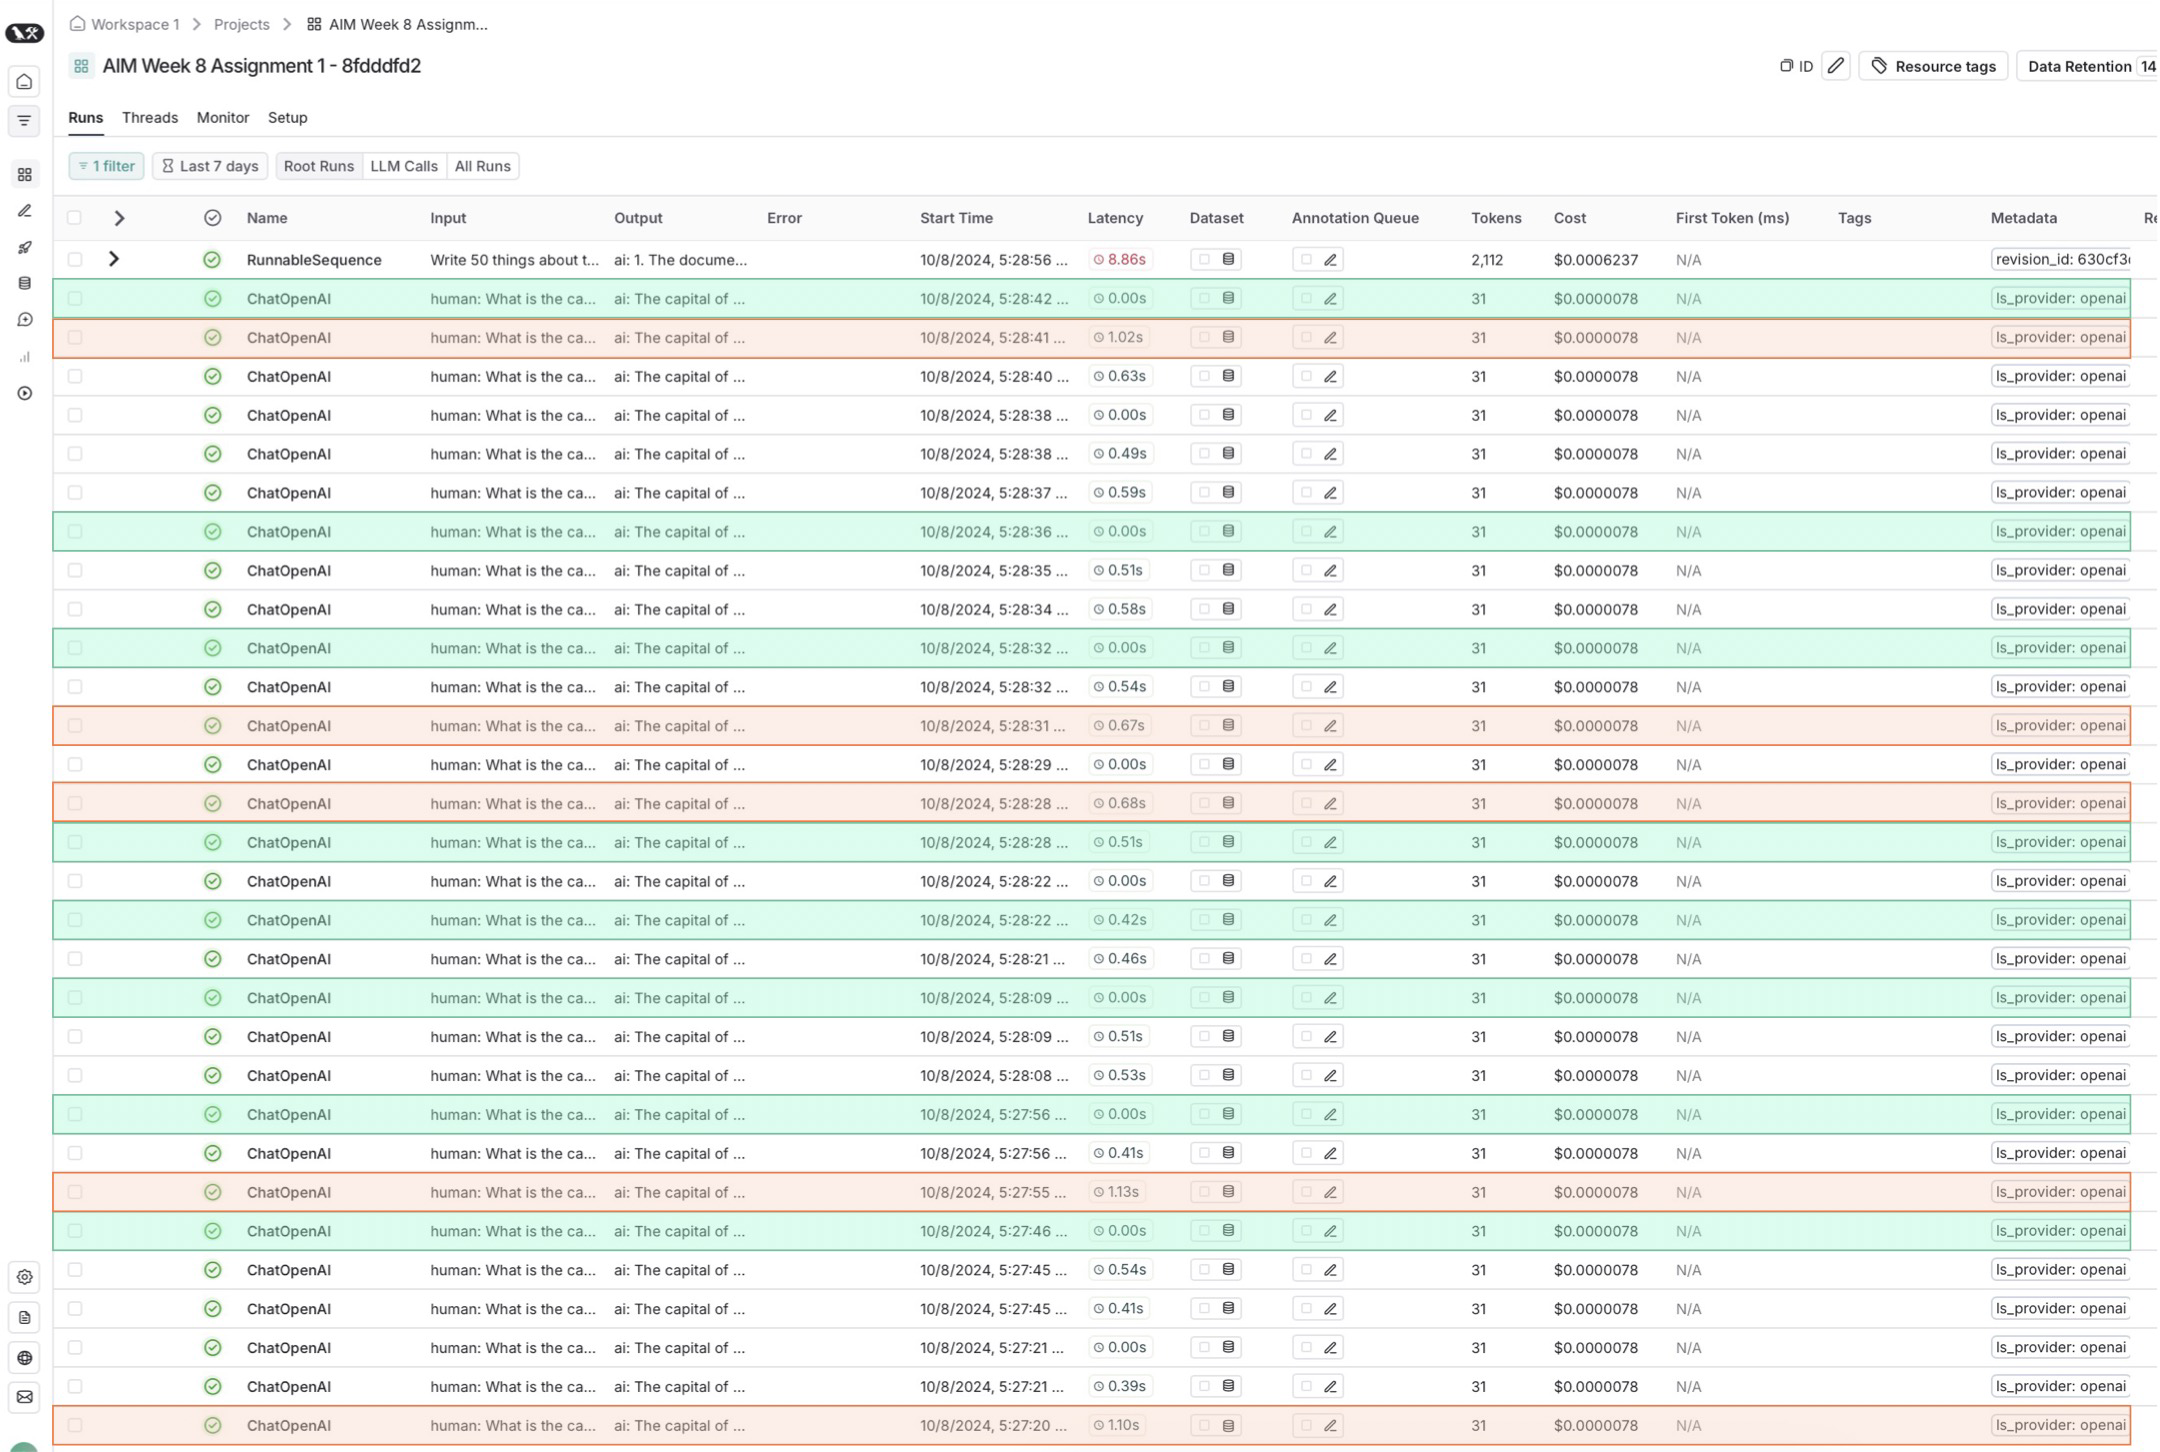